## Get random picture

In [1]:
import os
import random

def get_random_image_from_dataset(dataset_path=r'C:\Users\21654\OneDrive\Desktop\PPP\DATA\OOD.v1i.yolov8\test\images'):
    # Get all image files in the dataset folder
    image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    # Randomly select an image
    random_image = random.choice(image_files)
    # Return the full path of the selected image
    return os.path.join(dataset_path, random_image)
    # return r'C:\Users\21654\OneDrive\Desktop\PPP\DATA\OOD.v1i.yolov8\test\images\2f8f7add9adebcc4_jpg.rf.a7f98e7f99627885c902ce432ce89de8.jpg'

## Get Model

In [10]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

net = models.get(Models.YOLO_NAS_S, pretrained_weights="coco")

C:\Users\21654\.conda\envs\nas-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train Model

Imports

In [24]:
import os
import shutil
from super_gradients.training import models, Trainer
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

Initialize Trainer

In [19]:
trainer = Trainer(
    experiment_name="yolo_nas_stairs_manholes", 
    ckpt_root_dir="checkpoints"
)

Load Pretrained Model

In [20]:
model = models.get(
    "yolo_nas_s", 
    pretrained_weights="coco", 
    num_classes=2  # Stairs + Manholes
).cuda()

Define Paths

In [22]:
# Define Paths
DATA_ROOT = r"C:\Users\21654\OneDrive\Desktop\PPP\DATA\SmartSight-Finetuned Dataset"

# Create Temporary Merged Folders
os.makedirs(os.path.join(DATA_ROOT, "merged_train", "images"), exist_ok=True)
os.makedirs(os.path.join(DATA_ROOT, "merged_train", "labels"), exist_ok=True)
os.makedirs(os.path.join(DATA_ROOT, "merged_val", "images"), exist_ok=True)
os.makedirs(os.path.join(DATA_ROOT, "merged_val", "labels"), exist_ok=True)

Merge Datasets 

In [25]:
# Copy Files Instead of Symlinking
def copy_files(src_folder, dst_folder, prefix=""):
    for file in os.listdir(src_folder):
        src_path = os.path.join(src_folder, file)
        dst_path = os.path.join(dst_folder, f"{prefix}{file}")
        shutil.copy(src_path, dst_path)

# Copy Training Data
for dataset in ["Stairs", "Manholes"]:
    copy_files(
        os.path.join(DATA_ROOT, dataset, "train", "images"),
        os.path.join(DATA_ROOT, "merged_train", "images"),
        f"{dataset}_"
    )
    copy_files(
        os.path.join(DATA_ROOT, dataset, "train", "labels"),
        os.path.join(DATA_ROOT, "merged_train", "labels"),
        f"{dataset}_"
    )

# Copy Validation Data
for dataset in ["Stairs", "Manholes"]:
    copy_files(
        os.path.join(DATA_ROOT, dataset, "val", "images"),
        os.path.join(DATA_ROOT, "merged_val", "images"),
        f"{dataset}_"
    )
    copy_files(
        os.path.join(DATA_ROOT, dataset, "val", "labels"),
        os.path.join(DATA_ROOT, "merged_val", "labels"),
        f"{dataset}_"
    )

Update data.yaml

In [26]:
data_yaml = f"""
train: {os.path.join(DATA_ROOT, "merged_train", "images")}
val: {os.path.join(DATA_ROOT, "merged_val", "images")}

nc: 2
names: ['manhole', 'stair']
"""

with open(os.path.join(DATA_ROOT, "data.yaml"), "w") as f:
    f.write(data_yaml)

Data Loaders 

In [27]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        "data_dir": DATA_ROOT,
        "images_dir": "merged_train/images",
        "labels_dir": "merged_train/labels",
        "classes": ["manhole", "stair"],
    },
    dataloader_params={"batch_size": 16}
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        "data_dir": DATA_ROOT,
        "images_dir": "merged_val/images",
        "labels_dir": "merged_val/labels",
        "classes": ["manhole", "stair"],
    },
    dataloader_params={"batch_size": 16}
)

Indexing dataset annotations: 100%|██████████| 55/55 [00:00<00:00, 57.36it/s]


Start Training

In [31]:
training_params = {
    "max_epochs": 50,
    "lr_mode": "cosine",
    "initial_lr": 0.01,
    "loss": PPYoloELoss(num_classes=2, use_static_assigner=False),
    "valid_metrics_list": [
        DetectionMetrics_050(
            num_cls=2,  # Number of classes
            score_thres=0.1,
            top_k_predictions=300,
            normalize_targets=True
        )
    ],
    "metric_to_watch": "mAP@0.50",
    "greater_metric_to_watch_is_better": True,
}

In [ ]:
trainer.train(
    model=model,
    training_params=training_params,
    train_loader=train_data,
    valid_loader=val_data,
)

Train epoch 0:  19%|█▉        | 14/73 [04:24<10:30, 10.69s/it, PPYoloELoss/loss=3.28, PPYoloELoss/loss_cls=1.39, PPYoloELoss/loss_dfl=1.01, PPYoloELoss/loss_iou=0.886, gpu_mem=8.95]   

Evaluate best checkpoint

In [ ]:
best_model = models.get(
    "yolo_nas_s",
    checkpoint_path=f"checkpoints/yolo_nas_stairs_manholes/average_model.pth",
    num_classes=2
)

metrics = trainer.test(
    model=best_model,
    test_loader=val_data,
    test_metrics_list=[DetectionMetrics_050()]
)

print(f"mAP@0.50: {metrics['mAP@0.50']}")

## Test Model

Predict

In [ ]:
image_path = get_random_image_from_dataset()
prediction = net.predict(image_path)

# Plot the results (image with bounding boxes)
prediction.show()

## Export Model

In [19]:
models.convert_to_onnx(model=net, input_shape=(3,640,640), out_path="YOLO-NAS-S-PretrainedModel/yolo_nas_s.onnx")

'YOLO-NAS-S-PretrainedModel/yolo_nas_s.onnx'

## Predict with exported model 

In [20]:
import cv2 
import onnxruntime as ort 
import numpy as np

# Load ONNX model
session = ort.InferenceSession("YOLO-NAS-S-PretrainedModel/yolo_nas_s.onnx")

In [21]:
def preprocess_image(image_path, input_size=(640, 640)):
    # Read image
    image = cv2.imread(image_path)
    orig_image = image.copy()
    orig_height, orig_width = image.shape[:2]
    
    # Convert to RGB and resize
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(image, input_size)
    
    # Normalize and transpose to (batch, channel, height, width)
    input_tensor = resized.transpose(2, 0, 1).astype(np.float32) / 255.0
    input_tensor = np.expand_dims(input_tensor, axis=0)
    
    return orig_image, input_tensor, (orig_width, orig_height)

In [22]:
def process_output(outputs, confidence_threshold=0.5, orig_size=None):
    # Outputs:
    # - outputs[0]: boxes [1, 8400, 4] (x1, y1, x2, y2)
    # - outputs[1]: class scores [1, 8400, 80]
    
    boxes = outputs[0].squeeze(0)  # Shape: [8400, 4]
    class_scores = outputs[1].squeeze(0)  # Shape: [8400, 80]

    # Get max scores and class IDs
    scores = np.max(class_scores, axis=1)  # Shape: [8400]
    class_ids = np.argmax(class_scores, axis=1)  # Shape: [8400]

    # Filter by confidence
    mask = scores > confidence_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    class_ids = class_ids[mask]

    if boxes.shape[0] == 0:
        return [], [], []

    # Scale boxes to original image size
    if orig_size is not None:
        orig_width, orig_height = orig_size
        input_width, input_height = 640, 640
        scale_x = orig_width / input_width
        scale_y = orig_height / input_height
        boxes[:, [0, 2]] *= scale_x
        boxes[:, [1, 3]] *= scale_y

    return boxes, scores, class_ids.astype(int)

In [23]:
def apply_nms(boxes, scores, iou_threshold=0.5):
    # Convert boxes to (x, y, w, h) format
    boxes_wh = np.zeros_like(boxes)
    boxes_wh[:, 0] = boxes[:, 0]
    boxes_wh[:, 1] = boxes[:, 1]
    boxes_wh[:, 2] = boxes[:, 2] - boxes[:, 0]  # width
    boxes_wh[:, 3] = boxes[:, 3] - boxes[:, 1]  # height
    
    # Apply NMS
    indices = cv2.dnn.NMSBoxes(boxes_wh.tolist(), scores.tolist(), 0.5, iou_threshold)
    if len(indices) > 0:
        indices = indices.flatten()
        return boxes[indices], scores[indices], class_ids[indices]
    else:
        return [], [], []

In [24]:
CLASS_NAMES = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
    "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
    "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
    "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
    "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote",
    "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book",
    "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush", "stairs"
]

def draw_boxes(image, boxes, scores, class_ids):
    for box, score, class_id in zip(boxes, scores, class_ids):
        x1, y1, x2, y2 = box.astype(int)
        
        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Create label
        label = f"{CLASS_NAMES[class_id]}: {score:.2f}"
        cv2.putText(image, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return image

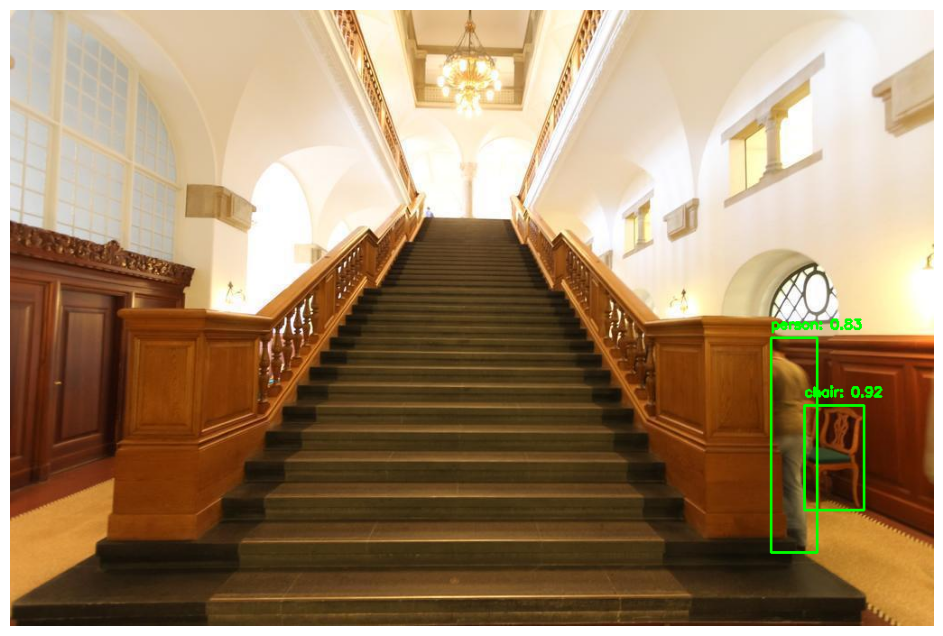

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Parameters
conf_threshold = 0.5
nms_threshold = 0.5

# Preprocess
orig_image, input_tensor, orig_size = preprocess_image(get_random_image_from_dataset())

# Inference
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: input_tensor})

# Process outputs
boxes, scores, class_ids = process_output(outputs, conf_threshold, orig_size)

# Apply NMS (convert to xywh format)
boxes_xywh = np.zeros_like(boxes)
boxes_xywh[:, 0] = (boxes[:, 0] + boxes[:, 2]) / 2  # center x
boxes_xywh[:, 1] = (boxes[:, 1] + boxes[:, 3]) / 2  # center y
boxes_xywh[:, 2] = boxes[:, 2] - boxes[:, 0]        # width
boxes_xywh[:, 3] = boxes[:, 3] - boxes[:, 1]        # height

indices = cv2.dnn.NMSBoxes(boxes_xywh.tolist(), scores.tolist(), conf_threshold, nms_threshold)

if len(indices) > 0:
    indices = indices.flatten()
    boxes = boxes[indices]
    scores = scores[indices]
    class_ids = class_ids[indices]

# Draw results
result_image = draw_boxes(orig_image, boxes, scores, class_ids)

# Display
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Evaluating the model 

In [8]:
from collections import defaultdict

class Evaluator:
    def __init__(self):
        self.all_pred_boxes = []
        self.all_pred_scores = []
        self.all_pred_classes = []
        self.all_gt_boxes = []
        self.all_gt_classes = []

    def calculate_iou(self, box1, box2):
        """Calculate Intersection over Union (IoU) between two boxes"""
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        
        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        
        return intersection / (area1 + area2 - intersection + 1e-6)

    def update(self, boxes, scores, class_ids, gt_boxes, gt_classes):
        """Store predictions and ground truth with shape validation"""
        # Ensure numpy arrays with proper shapes
        self.all_pred_boxes.append(np.asarray(boxes).reshape(-1, 4))
        self.all_pred_scores.append(np.asarray(scores).flatten())
        self.all_pred_classes.append(np.asarray(class_ids).flatten().astype(int))
        self.all_gt_boxes.append(np.asarray(gt_boxes).reshape(-1, 4))
        self.all_gt_classes.append(np.asarray(gt_classes).flatten().astype(int))

    def compute_map(self, iou_thresholds=np.linspace(0.5, 0.95, 10)):
        """Compute mAP across multiple IoU thresholds"""
        aps = []
        
        for thresh in iou_thresholds:
            # Per-threshold storage
            class_tp = defaultdict(list)
            class_fp = defaultdict(list)
            class_scores = defaultdict(list)
            class_num_gt = defaultdict(int)

            # Process all images
            for pred_b, pred_s, pred_c, gt_b, gt_c in zip(
                self.all_pred_boxes, self.all_pred_scores,
                self.all_pred_classes, self.all_gt_boxes, self.all_gt_classes
            ):
                # Process each class present in image
                for class_id in np.unique(np.concatenate([pred_c, gt_c])):
                    if class_id >= len(CLASS_NAMES):
                        continue
                    
                    # Filter predictions and ground truth
                    pred_mask = (pred_c == class_id)
                    gt_mask = (gt_c == class_id)
                    
                    # Get filtered boxes and scores
                    class_pred_boxes = pred_b[pred_mask]
                    class_pred_scores = pred_s[pred_mask]
                    class_gt_boxes = gt_b[gt_mask]

                    # Sort predictions by confidence
                    sorted_indices = np.argsort(-class_pred_scores)
                    class_pred_boxes = class_pred_boxes[sorted_indices]
                    class_pred_scores = class_pred_scores[sorted_indices]

                    # Initialize matching trackers
                    gt_used = np.zeros(len(class_gt_boxes), dtype=bool)
                    
                    # Match predictions to ground truth
                    for score, box in zip(class_pred_scores, class_pred_boxes):
                        best_iou = 0.0
                        best_gt_idx = -1
                        
                        for j, gt_box in enumerate(class_gt_boxes):
                            if not gt_used[j]:
                                iou = self.calculate_iou(box, gt_box)
                                if iou > best_iou:
                                    best_iou = iou
                                    best_gt_idx = j
                        
                        if best_iou >= thresh:
                            gt_used[best_gt_idx] = True
                            class_tp[class_id].append(1)
                            class_fp[class_id].append(0)
                        else:
                            class_tp[class_id].append(0)
                            class_fp[class_id].append(1)
                            
                        class_scores[class_id].append(score)
                    
                    # Update ground truth count
                    class_num_gt[class_id] += len(class_gt_boxes)

            # Calculate AP for this threshold
            threshold_aps = []
            for class_id in class_num_gt:
                if class_num_gt[class_id] == 0:
                    continue
                    
                # Sort detections by score
                scores = np.array(class_scores[class_id])
                tp = np.array(class_tp[class_id])
                fp = np.array(class_fp[class_id])
                
                indices = np.argsort(-scores)
                tp = tp[indices]
                fp = fp[indices]
                
                # Compute precision-recall curve
                tp_cumsum = np.cumsum(tp)
                fp_cumsum = np.cumsum(fp)
                
                recall = tp_cumsum / class_num_gt[class_id]
                precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
                
                # Compute AP using COCO-style interpolation
                ap = 0.0
                for t in np.linspace(0, 1, 101):
                    mask = recall >= t
                    if np.any(mask):
                        ap += np.max(precision[mask]) / 101
                        
                threshold_aps.append(ap)
            
            # Average AP across classes for this threshold
            mean_ap = np.mean(threshold_aps) if threshold_aps else 0.0
            aps.append(mean_ap)
        
        return {
            'map_50': aps[0],  # mAP@0.5
            'map': np.mean(aps)  # mAP@0.5:0.95
        }

In [9]:
def load_yolo_labels(label_path, image_width, image_height):
    """
    Load YOLO format labels and convert to absolute coordinates
    Returns: (boxes in [x1,y1,x2,y2] format, class_ids)
    """
    boxes = []
    class_ids = []
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        class_id, cx_norm, cy_norm, w_norm, h_norm = map(float, line.strip().split())
        
        # Convert normalized coordinates to absolute
        cx = cx_norm * image_width
        cy = cy_norm * image_height
        w = w_norm * image_width
        h = h_norm * image_height
        
        # Convert center to corner coordinates
        x1 = cx - w/2
        y1 = cy - h/2
        x2 = cx + w/2
        y2 = cy + h/2
        
        boxes.append([x1, y1, x2, y2])
        class_ids.append(int(class_id))
    
    return np.array(boxes), np.array(class_ids)

In [10]:
import os

def evaluate_model(session, input_name, val_image_dir, val_label_dir):
    evaluator = Evaluator(iou_threshold=0.5)
    
    for image_file in os.listdir(val_image_dir):
        if not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
            
        # Load and preprocess
        image_path = os.path.join(val_image_dir, image_file)
        orig_image, input_tensor, orig_size = preprocess_image(image_path)
        orig_width, orig_height = orig_size
        
        # Inference
        outputs = session.run(None, {input_name: input_tensor})
        boxes, scores, class_ids = process_output(outputs, orig_size=orig_size)
        
        # Load ground truth
        label_path = os.path.join(val_label_dir, 
                                os.path.splitext(image_file)[0] + ".txt")
        gt_boxes, gt_classes = load_yolo_labels(label_path, orig_width, orig_height)
        
        # Skip images with no ground truth
        if len(gt_boxes) == 0:
            continue
            
        # Update metrics
        evaluator.update(boxes, scores, class_ids, gt_boxes, gt_classes)
    
    return evaluator

In [11]:
val_image_dir = r'C:\Users\21654\OneDrive\Desktop\PPP\DATA\OOD.v1i.yolov8\valid\images'
val_label_dir = r'C:\Users\21654\OneDrive\Desktop\PPP\DATA\OOD.v1i.yolov8\valid\labels'

# Initialize model and evaluator
evaluator = Evaluator()

# Run evaluation on all validation images
for image_file in os.listdir(val_image_dir):
    if not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    
    # Load and preprocess image
    image_path = os.path.join(val_image_dir, image_file)
    orig_image, input_tensor, orig_size = preprocess_image(image_path)
    orig_width, orig_height = orig_size
    
    # Run inference
    outputs = session.run(None, {input_name: input_tensor})
    boxes, scores, class_ids = process_output(outputs, orig_size=orig_size)
    
    # Load ground truth
    label_path = os.path.join(val_label_dir, os.path.splitext(image_file)[0] + ".txt")
    gt_boxes, gt_classes = load_yolo_labels(label_path, orig_width, orig_height)
    
    # Skip images with no ground truth
    if len(gt_boxes) == 0:
        continue
    
    # Update evaluator
    evaluator.update(boxes, scores, class_ids, gt_boxes, gt_classes)

In [12]:
# Calculate and print metrics
metrics = evaluator.compute_map()
print(f"mAP@0.5: {metrics['map_50']:.4f}")
print(f"mAP@0.5:0.95: {metrics['map']:.4f}")

mAP@0.5: 0.0172
mAP@0.5:0.95: 0.0144


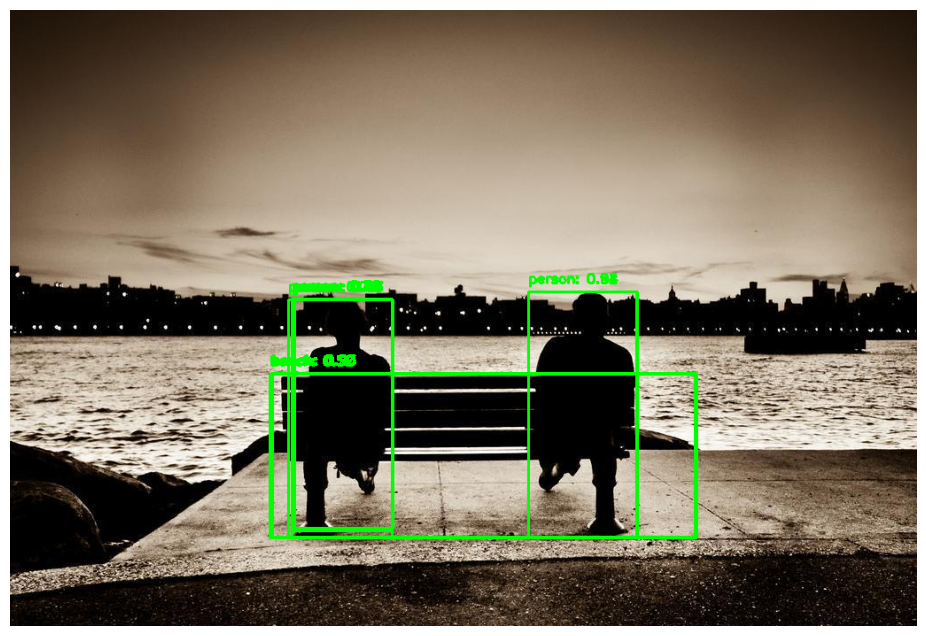

In [18]:
def visualize_sample(image_path):
    orig_image, input_tensor, orig_size = preprocess_image(image_path)
    outputs = session.run(None, {input_name: input_tensor})
    boxes, scores, class_ids = process_output(outputs, orig_size=orig_size)
    
    # Draw predictions
    for box, score, class_id in zip(boxes, scores, class_ids):
        x1, y1, x2, y2 = box.astype(int)
        color = (0, 255, 0)
        cv2.rectangle(orig_image, (x1, y1), (x2, y2), color, 2)
        label = f"{CLASS_NAMES[class_id]}: {score:.2f}"
        cv2.putText(orig_image, label, (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Visualize random sample
sample_image = os.path.join(val_image_dir, np.random.choice(os.listdir(val_image_dir)))
visualize_sample(sample_image)